In [1]:

from sentence_to_predicate import WordPredicate
import json
import sentence_grounding_test_parameters as param
import numpy as np
from recognized_object import RecognizedObject

from plots import *
from data_processing import *

import sys
import time
import matplotlib.pyplot as plt
import math
import os
import pandas as pd

from reservoirpy import ESNOnline, mat_gen, ESN
from reservoirpy.mat_gen import generate_internal_weights, generate_input_weights
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



In [2]:
#import keras
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Masking, GRU
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import BertModel, BertTokenizer
from transformers import pipeline

/home/subbainria/anaconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
def test_with_sentences_ESN(sentences, model, nb_concepts, threshold_factor):
    test = [one_hot_encoding_sentence(s) for s in sentences]
    res = []
    model.reset_reservoir()
    for i in range(len(sentences)):
        outputs, int_states = model.run([test[i],])
        res.append(outputs[0])
        model.reset_reservoir()
    return res, [output_to_vision(res[j][-1],nb_concepts, threshold_factor, concepts_delimitations, output_id_to_concept_dict) for j in range(len(res))]

In [4]:
def test_with_sentences(sentences, model):
    global max_seq_len
    test = [one_hot_encoding_sentence(s) for s in sentences]
    test_pad = padding(test, max_seq_len)
    res = model.predict(test_pad)
    return res

In [5]:
def is_a_valid_imagined_object(predicate, imagined_object):
    """
        Returns whether the predicate description could apply to the imagine_object.

        Inputs:
            predicate: WordPredicate instance
            imagined_object: RecognizedObject instance

    """

    #target = possible_recognized_object_for_predicate(predicate, fill_unkown_fields = False)

    for field in ['category', 'position', 'color']:

        wanted_field = getattr(predicate, field)

        if wanted_field is not None and getattr(imagined_object, field) != wanted_field:
            return False

    return True

def is_a_valid_representation(predicates, imagined_objects):
    """
        Returns whether each predicate  description could apply to its
        corresponding imagined_object.


        Inputs:
            predicates: a list of WordPredicate instances
            imagined_objects: a list of RecognizedObject instance
    """

    return all(map(is_a_valid_imagined_object, predicates, imagined_objects))




def is_an_exact_imagined_object(predicate, imagined_object):
    """
        Returns whether the imagined object matches exactly what the predicate
        describes.

        Inputs:
            predicate: WordPredicate instance
            imagined_object: RecognizedObject instance

    """
    #target = possible_recognized_object_for_predicate(predicate, fill_unkown_fields = False)

    for field in ['category', 'position', 'color']:

        if getattr(imagined_object, field) != getattr(predicate, field):
            return False

    return True

def is_an_exact_representation(predicates, imagined_objects):
    """
        Returns whether the imagined object matches exactly what the predicate
        describes.

        Inputs:
            predicates: a list of WordPredicate instances
            imagined_objects: a list of RecognizedObject instance
    """

    return all(map(is_an_exact_imagined_object, predicates, imagined_objects))

In [6]:
def generate_labels_valid(sentences):
    words = sentences.replace(".", "").split()
    obj = []
    col = []
    pos = []
    for w in words:
        if '<'+w+'_obj>' in concepts:
            obj.append('<'+w+'_obj>')
        if '<'+w+'_col>' in concepts:
            col.append('<'+w+'_col>')
        if '<'+w+'_pos>' in concepts:
            pos.append('<'+w+'_pos>')
    ss = ''
    if len(obj)>0:
        if len(pos)>0:
            if len(col)>0:
                return RecognizedObject(obj[0],pos[0],col[0])
            else:
                return RecognizedObject(obj[0],pos[0],None)
        else:
            if len(col)>0:
                return RecognizedObject(obj[0],None,col[0])
            else:
                return RecognizedObject(obj[0],None,None)
    else:
        if len(pos)>0:
            if len(col)>0:
                return RecognizedObject(None,pos[0],col[0])
            else:
                return RecognizedObject(None,pos[0],None)
        else:
            if len(col)>0:
                return RecognizedObject(None,None,col[0])
            else:
                return RecognizedObject(None,None,None)

In [7]:
def test_on_test_set(model, test_sentences, testX, testY, verbose, threshold_factor, online):
    test_outputs = []
    rmse = 0
    for sent_nb in range(len(testX)):
        if online:
            model.reset_reservoir()
        outputs, int_states = model.run([testX[sent_nb],])
        test_outputs.append(outputs[0][-1])
        rmse += np.mean( (outputs[0][-1] - testY[sent_nb])**2)
    rmse = np.sqrt(rmse/len(testX))

    if verbose:
        print("End of testing")
    exact = 0
    valid = 0
    for i in range(len(test_outputs)):
        v = output_to_vision(test_outputs[i],nb_concepts, threshold_factor, concepts_delimitations, output_id_to_concept_dict)
        #pred = sentence_to_pred(test_sentences[i], sent_to_role)
        pred = []
        clauses = test_sentences[i].split(" and ")
        if len(clauses) == 1:
            if len(test_sentences[i].split("."))>2:
                #print(s.split("."))
                pred.append(generate_labels_valid(test_sentences[i].split(".")[0]))
                pred.append(generate_labels_valid(test_sentences[i].split(".")[1]))
            else:
                pred.append(generate_labels_valid(test_sentences[i]))
                pred.append(RecognizedObject(None,None,None))
        else:
            for j in range(len(clauses)):
                pred.append(generate_labels_valid(clauses[j]))
        #print(v,pred)
        if is_an_exact_representation(pred, v):
            exact +=1

        if is_a_valid_representation(pred, v):
            valid +=1

        if is_a_valid_representation(pred, v) and not(is_an_exact_representation(pred, v)):
            pass

    nb_sample = len(testX)
    if verbose:
        print("Valid representations : ", valid,"/", nb_sample)
        print("Exact representations : ", exact, "/", nb_sample)
    return 1-valid/nb_sample, 1-exact/nb_sample, rmse

In [8]:
## to get the evolution of the loss during training
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.exact_errors = []
        self.valid_errors = []

    def on_epoch_end(self, epoch, logs=None):
        global validationX_pad
        global validationY
        self.losses.append(logs.get('loss'))

        v, ex, er = test_on_test_set(self.model, validationX_pad, validationY, validation_sentences, True, 1.3)

        self.val_losses.append(er)
        self.exact_errors.append(ex)
        self.valid_errors.append(v)

    def plot_loss(self):
        plt.figure()
        plt.plot(self.losses, color = "black", label = "loss")
        plt.plot(self.val_losses, color = "red", label = "loss on validation set")
        plt.xlabel("epochs of training")
        plt.title("MSE during training")
        plt.legend()
        plt.show()
        plt.figure()
        plt.title("Performance on validation set during training")
        plt.plot(self.exact_errors, color = "blue", label = "exact error")
        plt.plot(self.valid_errors, color = "green", label = "valid error")
        plt.legend()
        plt.show()

In [9]:
## functions used to create RSSviz showing the position of the errors
def getErrorScore(pred, obj):
    if is_an_exact_imagined_object(pred, obj):
        return 2
    elif is_a_valid_imagined_object(pred, obj):
        return 1
    else:
        return 0

def errorCode(obj_er):
    return (obj_er[0] + 3*obj_er[1])


def getErrorsInfo(reservoir_state, sentences, Wout, threshold_fact = 1.3):
    global nb_concepts, sent_to_role
    errors = []
    ind = 0
    for s in sentences:
        pred = sentence_to_pred(s, sent_to_role)
        for i in range(len(s.split(" "))):
            output = np.dot(Wout, reservoir_state[ind])
            v = output_to_vision(output,nb_concepts, threshold_fact,
                                 concepts_delimitations, output_id_to_concept_dict)
            obj_errors = (getErrorScore(pred[0], v[0]), getErrorScore(pred[1], v[1]))
            errors.append(errorCode(obj_errors))
            ind +=1
    return np.array(errors)

In [10]:
def get_int_states(model, sentences, one_chunck = True, only_last = False, get_obj_nb = False):

    test = [one_hot_encoding_sentence(s) for s in sentences]
    int_states_on_sent = []
    labels = []

    clause_nb = []

    for i in range(len(sentences)):
        model.reset_reservoir()
        outputs, int_states = model.run([test[i],])

        if only_last:
            int_states_on_sent.append(int_states[0][-1].reshape((int_states[0][-1].shape[0])))
        else:
            if one_chunck:
                for k in range(int_states[0].shape[0]):
                    int_states_on_sent.append(int_states[0][k].reshape((int_states[0][k].shape[0])))
            else:
                int_states_on_sent.append(int_states[0].reshape((int_states[0].shape[0], int_states[0].shape[1])))

            if get_obj_nb:
                words = sentences[i].split(" ")
                clause_id = 0
                for w in range(len(words)):
                    if words[w] == "and":
                        clause_id +=1
                    clause_nb.append(clause_id)
                    if words[w] == "and":
                        clause_id +=1
                clause_nb[-1] = 3 #final states

        words = sentences[i].split(" ")
        for j in range(1, len(words)+1):
            labels.append(" ".join(words[:j]))

    if one_chunck:
        int_states_on_sent = np.array(int_states_on_sent)

    if get_obj_nb:
        return int_states_on_sent, labels, np.array(clause_nb)
    else:
        return int_states_on_sent, labels

In [11]:
def plot_hidden_states(sentence, model_for_test, state = 'cell', units_to_plot = 'all', plt_var = False, plt_sum = False):
    activations = get_successive_outputs(sentence, model_for_test)

    plot_hidden_state_activation(sentence,
                                 activations,
                                 state,
                                 units_to_plot,
                                 plot_variation = plt_var,
                                 plot_sum = plt_sum)

In [30]:
dataset = pd.read_csv('./text.tsv', sep='\t')
dataset.dropna()
dataset.head()

,hit_id,worker_id,worktime_s,item_id,text
0,306996CF6WIITTJBR6Q44WPDCQ11BX,1717708c7af5468188e808a8d09b5c98,380,potato_3_2,A single small red skinned potato is laying on...
1,306996CF6WIITTJBR6Q44WPDCQ11BX,1717708c7af5468188e808a8d09b5c98,380,can_opener_4_3,The manual can opener has a black plastic hand...
2,306996CF6WIITTJBR6Q44WPDCQ11BX,1717708c7af5468188e808a8d09b5c98,380,measuring_tape_3_3,A pink and black measuring tape is laying on i...
3,306996CF6WIITTJBR6Q44WPDCQ11BX,1717708c7af5468188e808a8d09b5c98,380,fork_3_1,A silver metal fork is laying with its tines p...
4,306996CF6WIITTJBR6Q44WPDCQ11BX,1717708c7af5468188e808a8d09b5c98,380,can_opener_3_4,A manual can opener with a light blue plastic ...


In [31]:
dataset.shape

(8250, 5)

In [32]:
concepts = []
sentences = []
for i in np.arange(dataset.shape[0]):
    try:
        #print(i.split('_'))
        if len(dataset['item_id'][i].split('_')) == 3:
            concepts.append(dataset['item_id'][i].split('_')[0])
            sentences.append(dataset['text'][i])
        else:
            concepts.append(dataset['item_id'][i].split('_')[0]+" "+dataset['item_id'][i].split('_')[1])
            sentences.append(dataset['text'][i])
        #else:
        #    concepts.append(dataset['item_id'][i].split('_')[0]+dataset['item_id'][i].split('_')[1])
        #    sentences.append(dataset['text'][i].replace(dataset['item_id'][i].split('_')[0]+" "+dataset['item_id'][i].split('_')[1],dataset['item_id'][i].split('_')[0]+dataset['item_id'][i].split('_')[1]))
    except:
        continue

In [33]:
final_sentences = []
final_concepts = []
for s in sentences:
    try:
        if s.split(" "):
            final_sentences.append(s.lower())
    except:
        print(s)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [34]:
object_names = np.random.choice(np.unique(concepts),47, replace=False)

In [35]:
final = []
for i in final_sentences:
    for j in object_names:
        if j in i:
            final.append(i)

In [36]:
#object_names = np.unique(concepts)
color_names = ['red', 'black', 'blue', 'green', 'white', 'pink', 'orange','yellow']
position_names = ['left', 'right', 'middle', 'top', 'bottom', 'front', 'back']

In [37]:
def add_object(name, concept = None, build_after = True):
    
    if concept is None:
        concept = '<' + name.lower() + '_obj>'
    
    if name not in OBJECT_NAMES:
        OBJECT_NAMES.append(name)
        
    if concept not in CATEGORIES:
        CATEGORIES.append(concept)
        
    OBJ_NAME_TO_CONCEPT[name] = concept
    
    if build_after:
        build_all()
    
    
def add_position(name, concept = None, build_after=True):
    
    if concept is None:
        concept = '<' + name.lower() + '_pos>'
    
    if name not in POSITION_NAMES:
        POSITION_NAMES.append(name)
    
    if concept not in POSITIONS:
        POSITIONS.append(concept)
        
    POSITION_NAME_TO_CONCEPT[name] = concept
    
    if build_after:
        build_all()
       
        
def add_color(name, concept = None, build_after=True):
    
    if concept is None:
        concept = '<' + name.lower() + '_col>'
    
    
    if name not in COLOR_NAMES:
        COLOR_NAMES.append(name)
    
    if concept not in COLORS:
        COLORS.append(concept)
        
    COLOR_NAME_TO_CONCEPT[name] = concept
    
    if build_after:
        build_all()

In [38]:
# Words
OBJECT_NAMES = []
COLOR_NAMES = []
POSITION_NAMES = []

# Concepts
CATEGORIES = []
POSITIONS = []
COLORS = []

OBJ_NAME_TO_CONCEPT = dict()
COLOR_NAME_TO_CONCEPT = dict()
POSITION_NAME_TO_CONCEPT = dict()

In [39]:
for obj in object_names:
    add_object(obj, build_after = False)
        
for col in color_names:
    add_color(col, build_after = False)
        
for pos in position_names:
    add_position(pos, build_after = False)

In [40]:
################### MAIN #####################

## Parameters


add_begin_end = True #add the word "BEGIN" at the beggining and "END" at the end of all sentences ?
verbose_training = True
continuous_sentence_training = False # continuous or final training


use_save = False # use saved matrices from previous run ?
if use_save:
    name_id = '0.8885270787313605' #example random id of the files to load
    pth = r"saved_ESN/" #path to the saved arrays

threshold_factor = 1.3 # the factor used to get the threshold in the creation of he discrete representation
#nb_objects = np.unique(concepts).shape[0] #number of objects in the vocabulary used to generate the sentences (the bigger the harder)
N = 500 #the size of the reservoir
nb_objects = 47

#this code can be used in command line to specify the number of object and easily test different number of objects

minimal_mode = False #if minimal mode is on, the ESN will only be trained and tested on test set. The only text print will be "nb of objects, valid error on test set, exact error on test set, RMSE on test set, time to train"

In [41]:
other_words = []
if add_begin_end:
    other_words.append("BEGIN")
    other_words.append("END")

#init_one_hot_encoding(list(sent_to_role.keys()) + other_words)
#nb_unique_words = len(word2one_hot_id)

In [42]:
#concept dictionnary initialisation (it's the link between the output position and their meaning)
concepts = CATEGORIES + POSITIONS + COLORS

nb_concepts = len(concepts)

output_size = 2*nb_concepts

concept_to_output_id_dict = {}
output_id_to_concept_dict = {}
for i,c in enumerate(concepts):
    concept_to_output_id_dict[c] = i
    output_id_to_concept_dict[i] = c

In [43]:
concepts_delimitations = [(0,len(CATEGORIES)),
                          (len(CATEGORIES),
                          len(CATEGORIES) + len(POSITIONS)),
                          (len(CATEGORIES) + len(POSITIONS),
                          len(CATEGORIES) + len(POSITIONS)+ len(COLORS))]

In [48]:
##generate data
#we adjust the different dictionnaries to include sentences with BEGIN and END
final_sentences = final
if add_begin_end:
    for i in range(len(final_sentences)):
        final_sentences[0] = "BEGIN "+ final_sentences[0]+ " END"

In [49]:
#create the training, test and validation set

np.random.shuffle(final_sentences)

train_data = 1000

test_data = 4131


In [50]:
init_one_hot_encoding(final_sentences + other_words)
nb_unique_words = len(word2one_hot_id)

In [51]:
print(nb_unique_words)

2421


In [54]:
from nltk.tokenize.regexp import WhitespaceTokenizer

In [66]:
total = 0
for eachsent in train_sentences:
    tokens = WhitespaceTokenizer().tokenize(eachsent)
    #print(len(tokens))
    total+=len(tokens)
    
print(total/2421)

7.750103263114416


In [67]:
total = 0
for eachsent in test_sentences:
    tokens = WhitespaceTokenizer().tokenize(eachsent)
    #print(len(tokens))
    total+=len(tokens)
    
print(total/2421)

18.892193308550187


In [65]:
train_sentences = (final_sentences[:train_data])


test_sentences = (final_sentences[-test_data:])

In [37]:
concepts

['<gauze_obj>',
 '<picture frame_obj>',
 '<can opener_obj>',
 '<spoon_obj>',
 '<food can_obj>',
 '<measuring tape_obj>',
 '<cell phone_obj>',
 '<shampoo_obj>',
 '<lime_obj>',
 '<cap_obj>',
 '<sponge_obj>',
 '<water bottle_obj>',
 '<scissors_obj>',
 '<food jar_obj>',
 '<banana_obj>',
 '<notebook_obj>',
 '<band aid_obj>',
 '<toothpaste_obj>',
 '<eye glasses_obj>',
 '<lemon_obj>',
 '<prescription medicine_obj>',
 '<medicine bottle_obj>',
 '<coffee mug_obj>',
 '<pill cutter_obj>',
 '<marker_obj>',
 '<pliers_obj>',
 '<hand towel_obj>',
 '<apple_obj>',
 '<bowl_obj>',
 '<hammer_obj>',
 '<onion_obj>',
 '<mouse_obj>',
 '<stapler_obj>',
 '<flashlight_obj>',
 '<plate_obj>',
 '<allen wrench_obj>',
 '<fork_obj>',
 '<book_obj>',
 '<toothbrush_obj>',
 '<bell pepper_obj>',
 '<screwdriver_obj>',
 '<pencil_obj>',
 '<lightbulb_obj>',
 '<syringe_obj>',
 '<potato_obj>',
 '<soda bottle_obj>',
 '<tissue box_obj>',
 '<left_pos>',
 '<right_pos>',
 '<middle_pos>',
 '<top_pos>',
 '<bottom_pos>',
 '<front_pos>',


In [38]:
def generate_labels(sen_num, index_num, s):
    words = s.replace(".", "").split()
    for w in words:
        if '<'+w+'_obj>' in concepts:
            trainY[sen_num][index_num+concepts.index('<'+w+'_obj>')]=1
        if '<'+w+'_col>' in concepts:
            trainY[sen_num][index_num+concepts.index('<'+w+'_col>')]=1
        if '<'+w+'_pos>' in concepts:
            trainY[sen_num][index_num+concepts.index('<'+w+'_pos>')]=1

In [39]:
trainY = np.zeros([len(train_sentences),output_size])
print(trainY.shape)
i = 0
more_objects = []
for s in train_sentences:
    try:
        clauses = s.split(" and ")
        if len(clauses) == 1:
            if len(s.split("."))>2:
                #print(s.split("."))
                generate_labels(i, 0, s.split(".")[0])
                generate_labels(i, len(concepts), s.split(".")[1])
            else:
                generate_labels(i, 0, s)
        else:
            for j in range(len(clauses)):
                generate_labels(i, j*len(concepts), clauses[j])
    except:
        more_objects.append(i)
    i+=1

(1000, 124)


In [40]:
trainY = np.array(trainY)
trainY = np.delete(trainY,more_objects, axis=0)
print(trainY.shape)

(990, 124)


In [41]:
train_sentences = np.array(train_sentences)
train_sentences = np.delete(train_sentences,more_objects, axis=0)
print(train_sentences.shape)

(990,)


In [42]:
def generate_labels_test(sen_num, index_num, s):
    words = s.replace(".", "").split()
    for w in words:
        if '<'+w+'_obj>' in concepts:
            testY[sen_num][index_num+concepts.index('<'+w+'_obj>')]=1
        if '<'+w+'_col>' in concepts:
            testY[sen_num][index_num+concepts.index('<'+w+'_col>')]=1
        if '<'+w+'_pos>' in concepts:
            testY[sen_num][index_num+concepts.index('<'+w+'_pos>')]=1

In [43]:
testY = np.zeros([len(test_sentences),output_size])
i = 0
more_objects_test = []
for s in test_sentences:
    try:
        clauses = s.split(" and ")
        if len(clauses) == 1:
            if len(s.split("."))>2:
                #print(s.split("."))
                generate_labels_test(i, 0, s.split(".")[0])
                generate_labels_test(i, len(concepts), s.split(".")[1])
            else:
                generate_labels_test(i, 0, s)
        else:
            for j in range(len(clauses)):
                generate_labels_test(i, j*len(concepts), clauses[j])
    except:
        more_objects_test.append(i)
    i+=1

In [44]:
testY = np.array(testY)
testY = np.delete(testY,more_objects_test, axis=0)
print(testY.shape)

(4090, 124)


In [45]:
test_sentences = np.array(test_sentences)
test_sentences = np.delete(test_sentences,more_objects_test, axis=0)
print(test_sentences.shape)

(4090,)


In [46]:
trainX = [one_hot_encoding_sentence(s) for s in train_sentences]
#trainY = np.array([sentence_to_output_teacher_vector(s,
#                                                     concept_to_output_id_dict,
#                                                     nb_concepts) for s in train_sentences])


testX = [one_hot_encoding_sentence(s) for s in test_sentences]
#testY = np.array([sentence_to_output_teacher_vector(s,
#                                                    sent_to_role,
#                                                    concept_to_output_id_dict,
#                                                    nb_concepts) for s in test_sentences])


In [246]:
## create the ESN
iss = 1
nb_features = nb_unique_words
set_seed(None) #we test on a different and random seed each time

if continuous_sentence_training: # Alexis Juven's hyper-parameters optimized through random search
    sr = 1.3
    sparsity = 0.81
    leak = 0.04
    alpha_coef = 10.**(-3.7)
else:
    sr = 1.1
    sparsity = 0.85
    leak = 0.05
    alpha_coef = 10.**(-3.5)



# build an ESN online, i.e. trained with FORCE learning after each sample

W = mat_gen.fast_spectral_initialization(N, spectral_radius=sr, proba = sparsity) #reservoir matrix
Win = mat_gen.generate_input_weights(nbr_neuron=N, dim_input=nb_features, #input matrix
                                    input_bias=True, input_scaling=iss)
Wout = np.zeros((output_size, N+1)) #output matrix to be optimized


reservoir = ESNOnline(lr = leak,
                    W = W,
                    Win = Win,
                    Wout = Wout,
                    alpha_coef = alpha_coef)

In [47]:
for _ in np.arange(5):
    ## create the ESN
    iss = 1
    nb_features = nb_unique_words
    set_seed(None) #we test on a different and random seed each time

    if continuous_sentence_training: # Alexis Juven's hyper-parameters optimized through random search
        sr = 1.3
        sparsity = 0.81
        leak = 0.04
        alpha_coef = 10.**(-3.7)
    else:
        sr = 0.185
        sparsity = 0.2
        leak = 0.0174
        alpha_coef = 0.029



    # build an ESN online, i.e. trained with FORCE learning after each sample

    W = mat_gen.fast_spectral_initialization(N, spectral_radius=sr, proba = sparsity) #reservoir matrix
    Win = mat_gen.generate_input_weights(N=N, dim_input=nb_features, #input matrix
                                        input_bias=True, input_scaling=iss)
    Wout = np.zeros((output_size, N+1)) #output matrix to be optimized


    reservoir = ESNOnline(lr = leak,
                        W = W,
                        Win = Win,
                        Wout = Wout,
                        alpha_coef = alpha_coef)
    if __name__ == "__main__":

        if use_save:
            Wout = np.load(pth+"Wout"+name_id+".npy", allow_pickle = True)
            Win = np.load(pth+"Win"+name_id+".npy", allow_pickle = True)
            W = np.load(pth+"W"+name_id+".npy", allow_pickle = True)
            W = W.item()
            reservoir = ESNOnline(lr = leak,
                                W = W,
                                Win = Win,
                                Wout = Wout,
                                alpha_coef = alpha_coef)

        if not(use_save):
            t1 = time.process_time()

            for sent_nb in range(len(trainX)): #training sentences

                if continuous_sentence_training:
                    wash_init_steps = 0 #we train at each step
                else:
                    wash_init_steps = trainX[sent_nb].shape[0]-1 #we train only the last step


                reservoir.reset_reservoir()
                reservoir.train(inputs=np.array([trainX[sent_nb]]),
                                teachers=np.array([[trainY[sent_nb]]*trainX[sent_nb].shape[0]]), #the teacher is always the same vector
                                wash_nr_time_step=wash_init_steps,
                                verbose=False)


                if sent_nb%100 == 0 and verbose_training:
                    print("Advancement :")
                    print( sent_nb/len(trainX))


            t2 = time.process_time()
            if verbose_training:
                print("CPU Time to train : ", t2 - t1, " s")

            ##saving
            if not(minimal_mode):
                print("Saving the matrices ...")
                rd_id = np.random.random()
                print("ID for file saved : "+ str(rd_id))
                np.save(r"saved_ESN/Wout"+str(rd_id), Wout)
                np.save(r"saved_ESN/Win"+str(rd_id), Win)
                np.save(r"saved_ESN/W"+str(rd_id), W)
                print("Matrices saved !")

            ##Testing
            if verbose_training:
                print("Testing on test set...")
            vtest, extest, rmsetest = test_on_test_set(reservoir, test_sentences, testX, testY, verbose_training, threshold_factor, True)

            if minimal_mode:
                print(str(nb_objects) + "," +str(vtest) + "," + str(extest) + ","+ str(rmsetest) + "," + str(t2-t1))

            if not(minimal_mode):
                print("Testing on train set...") #to compare for overfitting estimation
                vtr, extr, rmsetr = test_on_test_set(reservoir, train_sentences, trainX, trainY, True, threshold_factor, True)


/home/subbainria/anaconda3/lib/python3.8/site-packages/reservoirpy-0.2.3.post1-py3.8.egg/reservoirpy/mat_gen.py:194: UserWarning: Deprecation warning: spectral_radius parameter is deprecated since 0.2.2 and will be removed. Please use sr instead.


Advancement :
0.0
Advancement :
0.10101010101010101
Advancement :
0.20202020202020202
Advancement :
0.30303030303030304
Advancement :
0.40404040404040403
Advancement :
0.5050505050505051
Advancement :
0.6060606060606061
Advancement :
0.7070707070707071
Advancement :
0.8080808080808081
Advancement :
0.9090909090909091
CPU Time to train :  25.831448758999997  s
Saving the matrices ...
ID for file saved : 0.283424836150985
Matrices saved !
Testing on test set...
End of testing
Valid representations :  3269 / 4090
Exact representations :  2960 / 4090
Testing on train set...
End of testing
Valid representations :  914 / 990
Exact representations :  857 / 990
Advancement :
0.0
Advancement :
0.10101010101010101
Advancement :
0.20202020202020202
Advancement :
0.30303030303030304
Advancement :
0.40404040404040403
Advancement :
0.5050505050505051
Advancement :
0.6060606060606061
Advancement :
0.7070707070707071
Advancement :
0.8080808080808081
Advancement :
0.9090909090909091
CPU Time to train :

In [46]:
for _ in np.arange(5):
    ## create the ESN
    iss = 1
    nb_features = nb_unique_words
    set_seed(None) #we test on a different and random seed each time

    if continuous_sentence_training: # Alexis Juven's hyper-parameters optimized through random search
        sr = 2.29
        sparsity = 0.2
        leak = 0.003
        alpha_coef = 0.01
    else:
        sr = 1.1
        sparsity = 0.85
        leak = 0.05
        alpha_coef = 10.**(-3.5)



    # build an ESN online, i.e. trained with FORCE learning after each sample

    W = mat_gen.fast_spectral_initialization(N, spectral_radius=sr, proba = sparsity) #reservoir matrix
    Win = mat_gen.generate_input_weights(N=N, dim_input=nb_features, #input matrix
                                        input_bias=True, input_scaling=iss)
    Wout = np.zeros((output_size, N+1)) #output matrix to be optimized


    reservoir = ESNOnline(lr = leak,
                        W = W,
                        Win = Win,
                        Wout = Wout,
                        alpha_coef = alpha_coef)
    if __name__ == "__main__":

        if use_save:
            Wout = np.load(pth+"Wout"+name_id+".npy", allow_pickle = True)
            Win = np.load(pth+"Win"+name_id+".npy", allow_pickle = True)
            W = np.load(pth+"W"+name_id+".npy", allow_pickle = True)
            W = W.item()
            reservoir = ESNOnline(lr = leak,
                                W = W,
                                Win = Win,
                                Wout = Wout,
                                alpha_coef = alpha_coef)

        if not(use_save):
            t1 = time.process_time()

            for sent_nb in range(len(trainX)): #training sentences

                if continuous_sentence_training:
                    wash_init_steps = 0 #we train at each step
                else:
                    wash_init_steps = trainX[sent_nb].shape[0]-1 #we train only the last step


                reservoir.reset_reservoir()
                reservoir.train(inputs=np.array([trainX[sent_nb]]),
                                teachers=np.array([[trainY[sent_nb]]*trainX[sent_nb].shape[0]]), #the teacher is always the same vector
                                wash_nr_time_step=wash_init_steps,
                                verbose=False)


                if sent_nb%100 == 0 and verbose_training:
                    print("Advancement :")
                    print( sent_nb/len(trainX))


            t2 = time.process_time()
            if verbose_training:
                print("CPU Time to train : ", t2 - t1, " s")

            ##saving
            if not(minimal_mode):
                print("Saving the matrices ...")
                rd_id = np.random.random()
                print("ID for file saved : "+ str(rd_id))
                np.save(r"saved_ESN/Wout"+str(rd_id), Wout)
                np.save(r"saved_ESN/Win"+str(rd_id), Win)
                np.save(r"saved_ESN/W"+str(rd_id), W)
                print("Matrices saved !")

            ##Testing
            if verbose_training:
                print("Testing on test set...")
            vtest, extest, rmsetest = test_on_test_set(reservoir, test_sentences, testX, testY, verbose_training, threshold_factor, True)

            if minimal_mode:
                print(str(nb_objects) + "," +str(vtest) + "," + str(extest) + ","+ str(rmsetest) + "," + str(t2-t1))

            if not(minimal_mode):
                print("Testing on train set...") #to compare for overfitting estimation
                vtr, extr, rmsetr = test_on_test_set(reservoir, train_sentences, trainX, trainY, True, threshold_factor, True)


Advancement :
0.0
Advancement :
0.10141987829614604
Advancement :
0.2028397565922921
Advancement :
0.30425963488843816
Advancement :
0.4056795131845842
Advancement :
0.5070993914807302
Advancement :
0.6085192697768763
Advancement :
0.7099391480730223
Advancement :
0.8113590263691683
Advancement :
0.9127789046653144
CPU Time to train :  430.93276290899985  s
Saving the matrices ...
ID for file saved : 0.30429287554894624
Matrices saved !
Testing on test set...
End of testing
Valid representations :  3214 / 4094
Exact representations :  2760 / 4094
Testing on train set...
End of testing
Valid representations :  861 / 986
Exact representations :  779 / 986
Advancement :
0.0
Advancement :
0.10141987829614604
Advancement :
0.2028397565922921
Advancement :
0.30425963488843816
Advancement :
0.4056795131845842
Advancement :
0.5070993914807302
Advancement :
0.6085192697768763
Advancement :
0.7099391480730223
Advancement :
0.8113590263691683
Advancement :
0.9127789046653144
CPU Time to train :  

In [50]:
continuous_sentence_training = True
for _ in np.arange(5):
    ## create the ESN
    iss = 1
    nb_features = nb_unique_words
    set_seed(None) #we test on a different and random seed each time

    if continuous_sentence_training: # Alexis Juven's hyper-parameters optimized through random search
        sr = 0.185
        sparsity = 0.2
        leak = 0.0174
        alpha_coef = 0.029
    else:
        sr = 1.1
        sparsity = 0.85
        leak = 0.05
        alpha_coef = 10.**(-3.5)



    # build an ESN online, i.e. trained with FORCE learning after each sample

    W = mat_gen.fast_spectral_initialization(N, spectral_radius=sr, proba = sparsity) #reservoir matrix
    Win = mat_gen.generate_input_weights(N=N, dim_input=nb_features, #input matrix
                                        input_bias=True, input_scaling=iss)
    Wout = np.zeros((output_size, N+1)) #output matrix to be optimized


    reservoir = ESNOnline(lr = leak,
                        W = W,
                        Win = Win,
                        Wout = Wout,
                        alpha_coef = alpha_coef)
    if __name__ == "__main__":

        if use_save:
            Wout = np.load(pth+"Wout"+name_id+".npy", allow_pickle = True)
            Win = np.load(pth+"Win"+name_id+".npy", allow_pickle = True)
            W = np.load(pth+"W"+name_id+".npy", allow_pickle = True)
            W = W.item()
            reservoir = ESNOnline(lr = leak,
                                W = W,
                                Win = Win,
                                Wout = Wout,
                                alpha_coef = alpha_coef)

        if not(use_save):
            t1 = time.process_time()

            for sent_nb in range(len(trainX)): #training sentences

                if continuous_sentence_training:
                    wash_init_steps = 0 #we train at each step
                else:
                    wash_init_steps = trainX[sent_nb].shape[0]-1 #we train only the last step


                reservoir.reset_reservoir()
                reservoir.train(inputs=np.array([trainX[sent_nb]]),
                                teachers=np.array([[trainY[sent_nb]]*trainX[sent_nb].shape[0]]), #the teacher is always the same vector
                                wash_nr_time_step=wash_init_steps,
                                verbose=False)


                if sent_nb%100 == 0 and verbose_training:
                    print("Advancement :")
                    print( sent_nb/len(trainX))


            t2 = time.process_time()
            if verbose_training:
                print("CPU Time to train : ", t2 - t1, " s")

            ##saving
            if not(minimal_mode):
                print("Saving the matrices ...")
                rd_id = np.random.random()
                print("ID for file saved : "+ str(rd_id))
                np.save(r"saved_ESN/Wout"+str(rd_id), Wout)
                np.save(r"saved_ESN/Win"+str(rd_id), Win)
                np.save(r"saved_ESN/W"+str(rd_id), W)
                print("Matrices saved !")

            ##Testing
            if verbose_training:
                print("Testing on test set...")
            vtest, extest, rmsetest = test_on_test_set(reservoir, test_sentences, testX, testY, verbose_training, threshold_factor, True)

            if minimal_mode:
                print(str(nb_objects) + "," +str(vtest) + "," + str(extest) + ","+ str(rmsetest) + "," + str(t2-t1))

            if not(minimal_mode):
                print("Testing on train set...") #to compare for overfitting estimation
                vtr, extr, rmsetr = test_on_test_set(reservoir, train_sentences, trainX, trainY, True, threshold_factor, True)


Advancement :
0.0
Advancement :
0.10101010101010101
Advancement :
0.20202020202020202
Advancement :
0.30303030303030304
Advancement :
0.40404040404040403
Advancement :
0.5050505050505051
Advancement :
0.6060606060606061
Advancement :
0.7070707070707071
Advancement :
0.8080808080808081
Advancement :
0.9090909090909091
CPU Time to train :  136.70021620099988  s
Saving the matrices ...
ID for file saved : 0.31350221530516387
Matrices saved !
Testing on test set...
End of testing
Valid representations :  3238 / 4090
Exact representations :  2572 / 4090
Testing on train set...
End of testing
Valid representations :  898 / 990
Exact representations :  786 / 990
Advancement :
0.0
Advancement :
0.10101010101010101
Advancement :
0.20202020202020202
Advancement :
0.30303030303030304
Advancement :
0.40404040404040403
Advancement :
0.5050505050505051
Advancement :
0.6060606060606061
Advancement :
0.7070707070707071
Advancement :
0.8080808080808081
Advancement :
0.9090909090909091
CPU Time to train

In [254]:
##Testing
if verbose_training:
    print("Testing on test set...")
    vtest, extest, rmsetest = test_on_test_set(reservoir, test_sentences, testX, testY, verbose_training, threshold_factor, True)

    if minimal_mode:
        print(str(nb_objects) + "," +str(vtest) + "," + str(extest) + ","+ str(rmsetest) + "," + str(t2-t1))

    if not(minimal_mode):
        print("Testing on train set...") #to compare for overfitting estimation
        vtr, extr, rmsetr = test_on_test_set(reservoir, train_sentences, trainX, trainY, True, threshold_factor, True)


Testing on test set...
End of testing
Valid representations :  4202 / 5137
Exact representations :  2622 / 5137
Testing on train set...
End of testing
Valid representations :  976 / 992
Exact representations :  948 / 992


In [45]:
test_sentences[0:10]

array(['a pair of black sissors.', 'this is a light bulb.',
       'this is a white plastic spoon.',
       'this is a blue bowl. it is made of porcelain.',
       'a black ball point pen', 'a wooden handled mallet.',
       'this is a pen which is used to write things down.',
       'here are a pair of pliers. it has pink, rubber handles.',
       'a silver fork', 'it is a hammer. it is pink, black, and silver.'],
      dtype='<U51892')

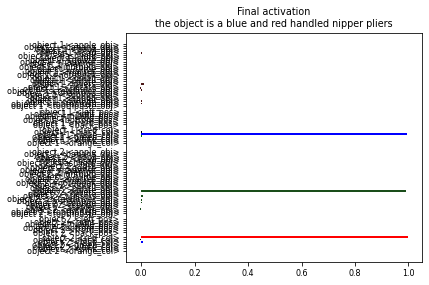

D:\Inria_Projects\esn-vs-lstm-on-cross-situationnal-learning\plots.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


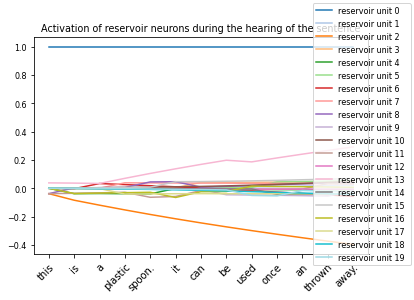

In [271]:
if not(minimal_mode):
        ##Qualitative testing

        #sample sentences for model analysis
        test_sent = ['this is a plastic spoon. it can be used once an thrown away.',
       'a stainless steel dinner fork.',
       'the object is a blue and red handled nipper pliers',
       'a red china pasta plate.', 'a lightbulb',
       'an item usually worn on the head. it is made of cloth and has a brim',
       'the object is a blue dry erase marker.',
       'the object is a clear syringe with a needle attached.',
       'a silver pair of scissors',
       'it is a brown and white sponge with an abrasive side.',"BEGIN on the middle is a green glass and that is a orange bowl END"] #9


        outputs, vision = test_with_sentences_ESN(test_sent, reservoir, nb_concepts, threshold_factor)

        #plot final outputs on the first test sentence
        id = 2
        plot_final_activation(outputs[id][-1], concepts_delimitations, output_id_to_concept_dict, nb_concepts, test_sent[id])


        #plot and save to png the evolution of the outputs during the processing of the first test sentence (plots developped by Alexis Juven)


        id = 2
        s = test_sent[id]

        if continuous_sentence_training:
            output_fun = lambda x: x
        else:
            output_fun = sigmoid #sigmoid function is recommended when dealing with final learning

        plot_concept_activation(s,
                                outputs[id],
                                concepts_delimitations,
                                nb_concepts,
                                savefig = True,
                                sub_ttl_fig = s+ " ESN",
                                output_function = output_fun)


        ##reservoir activity visualisation
        res_states, vis = test_with_sentences_ESN(test_sentences, reservoir, nb_concepts, 1)
        s = test_sentences[0]

        res_act , _ = get_int_states(reservoir, [s], one_chunck = False) #get reservoir states

        plot_hidden_state_activation(s,
                                    [res_act[0]],
                                    state='reservoir',
                                    units_to_plot = [i for i in range(20)], #plot the activation of the 20 first reseroir units (arbitrary choice)
                                    plot_variation = False,
                                    plot_sum = False)

In [269]:
CONCEPT_LISTS = [
            CATEGORIES,
            POSITIONS,
            COLORS
            ]
def plot_concept_activation(sentence, activations, concepts_delim,nb_concepts, output_function = None, savefig=False, sub_ttl_fig='', ylims=(-0.4, 1.4)):
    """
        Plots activation through time of the different concepts while hearing
        the sentence. If output_function is not None, it is applied to the reservoir
        output vector before plotting.
        This is a reuse of a function developped by Alexis Juven.
    """

    outputs = activations.copy()
    activation_threshold = 0.5

    if output_function is not None:

        activation_threshold = output_function(activation_threshold)

        for i in range(outputs.shape[0]):
            outputs[i, :] = output_function(outputs[i, :])


    words = sentence.split(" ")
    max_nb_seen_objects = 2
    nb_object_properties = 3

    fig, axes = plt.subplots(nb_object_properties, max_nb_seen_objects, figsize=(25,20))


    concept_delimitations = [t[0] for t in concepts_delim] + [concepts_delim[-1][1]]

    for i in range(max_nb_seen_objects):

        offset = i * nb_concepts

        axes[0, i].set_title("Object " + str(i+1), fontsize = 22)

        for j in range(nb_object_properties):

            ax = axes[j, i]
            ax.plot(outputs[:, offset + concept_delimitations[j] : offset + concept_delimitations[j+1]], linewidth = 4)
            ax.legend(CONCEPT_LISTS[j], loc = 2, fontsize = 22)

            ax.set_yticks([0., 0.5, 1.])
            ax.set_yticklabels([0., 0.5, 1.], fontsize = 20)

            ax.set_ylim([ylims[0], ylims[1]])

            ax.set_xticks(np.arange(len(words)))
            ax.set_xticklabels(words, fontsize = 24)
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize = 22)

            ax.plot(len(words) * [activation_threshold], '--', color = 'grey', linewidth = 3)

    fig.suptitle(sentence, fontsize = 26)
    plt.subplots_adjust(hspace = 0.3)

    if savefig:
        plt.savefig('sentence_'+sub_ttl_fig+".png", bbox_inches='tight')
        plt.close()
    else:
        fig.show()
        #plt.show()
